In [7]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils


import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings


In [24]:
pip install --upgrade numpy

  Using cached numpy-1.21.4-cp38-cp38-win_amd64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
apache-beam 2.34.0 requires numpy<1.21.0,>=1.14.3, but you have numpy 1.21.4 which is incompatible.


In [20]:
pip install pyparsing==2.4.2


  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.4
    Uninstalling pyparsing-3.0.4:

      Successfully uninstalled pyparsing-3.0.4


# **Navigate through the folder and display random images for verification**

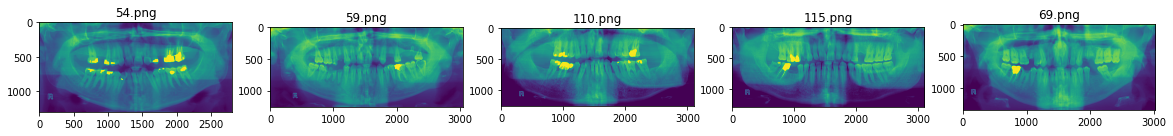

In [3]:
plt.figure(figsize=(20,20))
import random
img_folder=r'C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/InitImages'
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# **Define a function for automatic brightness and contrast**

In [4]:
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram from the grayscale image
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values for our function to output as well as,
    # weights which will be used to call the cv2 function fpr contrast and brightness
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

# Preprocessing Of The dataset

### Our dataset consists of a limited 116 images.This is due to the fact that the dental records of a patient is highly sensitive and for it to be open source could be a potential threat to the hospital and the doctor. The dataset we have used was approved by the patients of Noor Medical Imaging Center, Qom, Iran for medical research.

### To properly label the data we are required to do some enhancements, namely - contrast and brightness correction and resolution tweaking. We use laplacian pyramids and the cv2 (addWeighted) function for this purpose.

### Laplacian pyramids help create a variety of the same image of different resolutions which becomes quite useful when there is a case of edge detecton or face detections

<img width="500" height="500" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Image_pyramid.svg/1200px-Image_pyramid.svg.png">

### For our project, it is essential for us to label the teeth that have clear signs of reconstructions, fillings or endodontic and thus we require an image that gives us the perfect amount of detail. We rougly tweak the pyramid levels for this as shown below

## Tweaking The laplacian pyramid

In [8]:
#Function to display images in line
def imshow(image):
    width_height_1 = (100, 100)

    plt.figure(figsize=width_height_1)
    plt.imshow(image)
    plt.show()

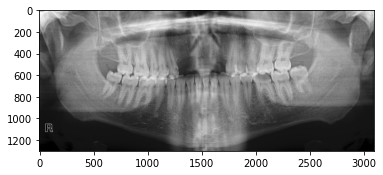

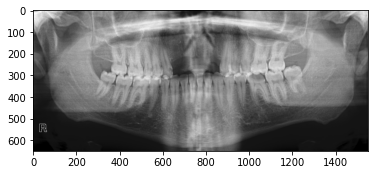

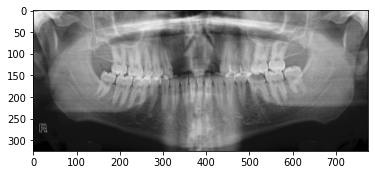

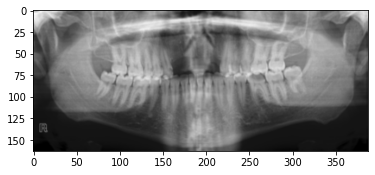

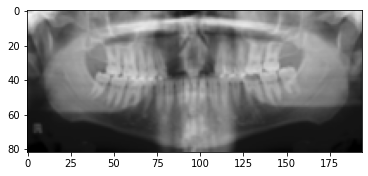

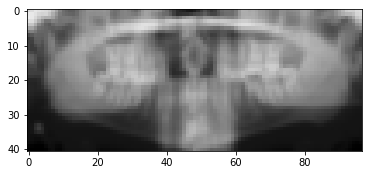

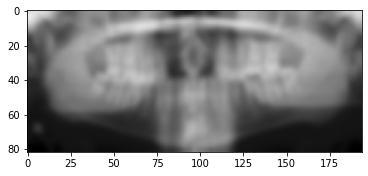

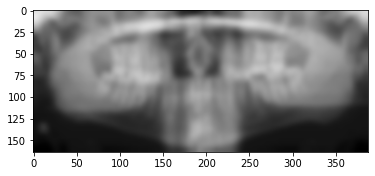

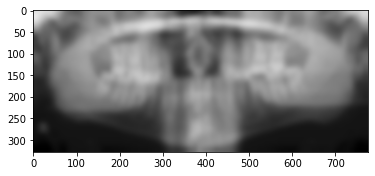

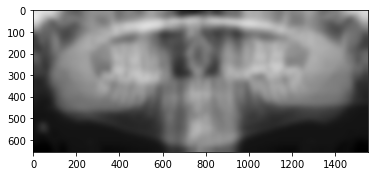

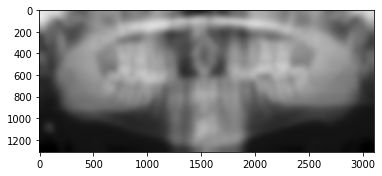

In [7]:
image = cv2.imread('C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/InitImages/1.png')
            
g0=cv2.pyrDown(image)
g1=cv2.pyrDown(g0)
g2=cv2.pyrDown(g1)
g3=cv2.pyrDown(g2)
g4=cv2.pyrDown(g3)
h3=cv2.pyrUp(g4)
h2=cv2.pyrUp(h3)
h1=cv2.pyrUp(h2)
h0=cv2.pyrUp(h1)
originallvl=cv2.pyrUp(h0)

imshow(image)
imshow(g0)
imshow(g1)
imshow(g2)
imshow(g3)
imshow(g4)
imshow(h3)
imshow(h2)
imshow(h1)
imshow(h0)
imshow(originallvl)


C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET
C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/InitImages
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img1 InitImages 1.png
1


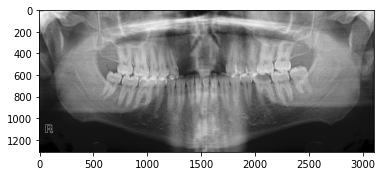

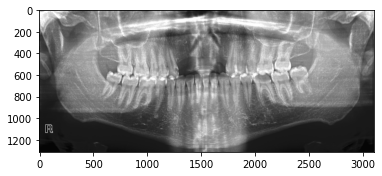

['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img2 InitImages 10.png
2


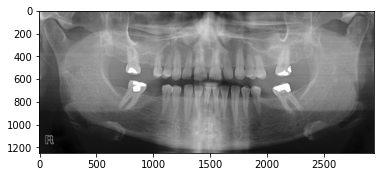

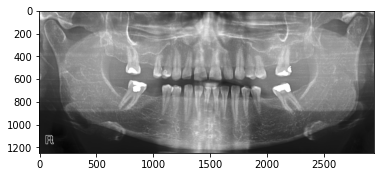

['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img3 InitImages 100.png
3
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img4 InitImages 101.png
4
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img5 InitImages 102.png
5
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img6 InitImages 103.png
6
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img7 InitImages 104.png
7
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomD

46
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img47 InitImages 36.png
47
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img48 InitImages 37.png
48
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img49 InitImages 38.png
49
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img50 InitImages 39.png
50
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img51 InitImages 4.png
51
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', '

90
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img91 InitImages 76.png
91
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img92 InitImages 77.png
92
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img93 InitImages 78.png
93
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img94 InitImages 79.png
94
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', 'CustomDetection', 'images', 'InitImages']
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET/img95 InitImages 8.png
95
['C:', 'Users', 'hnsik', 'Softwares', 'Tensorflow', '

In [8]:
os.chdir("C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/")
cwd=os.getcwd()
print(cwd)
cwd=os.path.join(cwd,'DATASET')
listImage=[]
i=0
print(cwd)

for(dirname, dirs, files) in os.walk('C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/InitImages'):
  print(dirname)
  for filename in files:
        if filename.endswith('.jpg') :
            print('ignore')
        if filename.endswith('.png') :
 
            i=i+1
            image = cv2.imread(os.path.join(dirname,filename))
            #Adding and Subtracting pyramid layers to find a desired result
            g0=cv2.pyrDown(image)
            g1=cv2.pyrDown(g0)
            g2=cv2.pyrDown(g1)
            g3=cv2.pyrDown(g2)
            g4=cv2.pyrDown(g3)
            h3=cv2.pyrUp(g4)
            h2=cv2.pyrUp(h3)
            h1=cv2.pyrUp(h2)
            h0=cv2.pyrUp(h1)
            originallvl=cv2.pyrUp(h0)

            x,y,z=originallvl.shape
            image=cv2.resize(image,(y,x))

            g0=cv2.pyrDown(image)
            g1=cv2.pyrDown(g0)
            g2=cv2.pyrDown(g1)
            g3=cv2.pyrDown(g2)
            g4=cv2.pyrDown(g3)
            h3=cv2.pyrUp(g4)
            h2=cv2.pyrUp(h3)
            h1=cv2.pyrUp(h2)
            h0=cv2.pyrUp(h1)
            l0=cv2.subtract(g0,h0)
            
            lr0=cv2.resize(l0,(y,x))
            
            norm0=cv2.normalize(lr0,None,0,255,cv2.NORM_MINMAX)
            rn0=cv2.add(image,lr0)

            new_image = cv2.convertScaleAbs(rn0, alpha=1, beta=5)
            name=dirname.split('/')
            print(name)                   
            name1=cwd+"/img"+str(i)+" "+name[-1]+" "+filename
            print(name1)
            cv2.imwrite(name1,new_image)  
            listImage.append(name1.split('/')[-1])   
            #Split the newly obtained image and add it into a different directory         
            print(i)
            if i<=2:
              imshow(image)
              imshow(new_image)

## Create a function to resize the images for easier computation

C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\DATASET


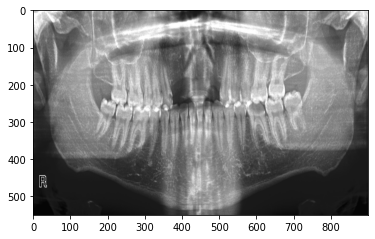

In [12]:
os.chdir("C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/DATASET")
print(os.getcwd())
x=listImage
counth=[]
countw=[]
count=0
i=1
for(dirname, dirs, files) in os.walk('.'):
    for filename in files:
        if filename in x:
          
            image = cv2.imread(filename)
    
            counth.append(image.shape[0])
            countw.append(image.shape[1])
            count=count+1
            im=cv2.resize(image,(900,550))
            cv2.imwrite(filename,im)
            if i==1:
                imshow(im)
            i+=1
            
        else:
            print('false')
            image=cv2.imread(filename)
            im=cv2.resize(image,(10,10))
            cv2.imwrite(filename,im)

## Navigate through the directories and apply contrast function

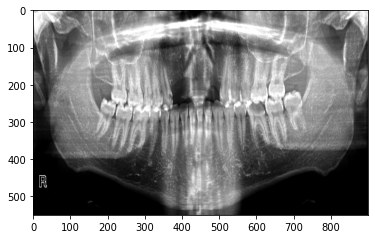

In [15]:
i=1
for(dirname, dirs, files) in os.walk('.'):
    for filename in files:
        if filename in x:
            image = cv2.imread(filename)
      
            auto_result,alpha,beta=automatic_brightness_and_contrast(image,2)
            result=cv2.addWeighted(auto_result,alpha,np.zeros(auto_result.shape,auto_result.dtype),0,beta)
            cv2.imwrite(filename,result)
            if i==1:
                imshow(result)
            i+=1

In [20]:
!cp -a C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/DATASET C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/Enhanced

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
CUSTOM_PATH="C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/"
PRE_TRAINED=CUSTOM_PATH+"pre-trained-models"

In [2]:
cd "C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/pre-trained-models"

C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\pre-trained-models


In [4]:
PRE_TRAINED

'C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/pre-trained-models'

In [11]:
cd models/els

[WinError 2] The system cannot find the file specified: 'models/els'
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection


## Extract Pretrained models

### ssd_resnet101_v1_fpn_640x640

In [13]:
!tar -xvf ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz

x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/pipeline.config
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/saved_model.pb
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/assets/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.index
2021-12-02 00:39:03.838503: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

### ssd_mobilenet_v2_fpnlite_320x320

In [16]:
!tar -xvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


### ssd_mobilenet_v2_320x320_coco17

In [10]:
!tar -xvf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

x ssd_mobilenet_v2_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/variables/variables.index


### efficientdet_d0_coco17_tpu-32.tar.gz

In [4]:
!tar -xvf efficientdet_d0_coco17_tpu-32.tar.gz

x efficientdet_d0_coco17_tpu-32/
x efficientdet_d0_coco17_tpu-32/checkpoint/
x efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
x efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
x efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
x efficientdet_d0_coco17_tpu-32/pipeline.config
x efficientdet_d0_coco17_tpu-32/saved_model/
x efficientdet_d0_coco17_tpu-32/saved_model/saved_model.pb
x efficientdet_d0_coco17_tpu-32/saved_model/assets/
x efficientdet_d0_coco17_tpu-32/saved_model/variables/
x efficientdet_d0_coco17_tpu-32/saved_model/variables/variables.data-00000-of-00001
x efficientdet_d0_coco17_tpu-32/saved_model/variables/variables.index


### faster_rcnn_resnet50

In [4]:
!tar -xvf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz

x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/checkpoint
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline.config
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/saved_model.pb
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/variables/
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/variables/variables.index


### centernet_hg104_512x512

In [3]:
!tar -xvf centernet_hg104_512x512_coco17_tpu-8.tar.gz

x centernet_hg104_512x512_coco17_tpu-8/
x centernet_hg104_512x512_coco17_tpu-8/checkpoint/
x centernet_hg104_512x512_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x centernet_hg104_512x512_coco17_tpu-8/checkpoint/checkpoint
x centernet_hg104_512x512_coco17_tpu-8/checkpoint/ckpt-0.index
x centernet_hg104_512x512_coco17_tpu-8/pipeline.config
x centernet_hg104_512x512_coco17_tpu-8/saved_model/
x centernet_hg104_512x512_coco17_tpu-8/saved_model/saved_model.pb
x centernet_hg104_512x512_coco17_tpu-8/saved_model/assets/
x centernet_hg104_512x512_coco17_tpu-8/saved_model/variables/
x centernet_hg104_512x512_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x centernet_hg104_512x512_coco17_tpu-8/saved_model/variables/variables.index


In [5]:
!tar -xvf ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz

x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/pipeline.config
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/saved_model.pb
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/assets/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.index


## Converting Image format and edit xml attribute

In [7]:
from PIL import Image
import os
import xml.etree.ElementTree as ET

In [8]:
for(dirname, dirs, files) in os.walk('C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/dentalTrain'):
    for filename in files:
     
            if filename.endswith('.xml'):
                name=f'C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/dentalTrain/{filename}'
                xmlTree = ET.parse(name)
               
                rootElement = xmlTree.getroot()
                print( rootElement.find("filename").text)
                rootElement.find("filename").text=f"{filename.split('.')[0]}.png"
                print( rootElement.find("filename").text)
                rootElement.find("path").text=f"C:\\Users\\hnsik\\Softwares\\Tensorflow\\CustomDetection\\images\\dentalTrain\\{filename.split('.')[0]}.png"
                print(rootElement.find("path").text)
                xmlTree.write(name)

img1 Images 26
img1 Images 26.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTrain\img1 Images 26.png
img10 Images 37
img10 Images 37.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTrain\img10 Images 37.png
img100 Images 3
img100 Images 3.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTrain\img100 Images 3.png
img101 Images 13
img101 Images 13.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTrain\img101 Images 13.png
img102 Images 12
img102 Images 12.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTrain\img102 Images 12.png
img103 Images 11
img103 Images 11.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTrain\img103 Images 11.png
img104 Images 10
img104 Images 10.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTrain\img104 Images 10.png
img105 Images 9
img105 Images 9.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalT

In [9]:
for(dirname, dirs, files) in os.walk('C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/dentalTest'):
    for filename in files:
      
            if filename.endswith('.xml'):
                name=f'C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/dentalTest/{filename}'
                xmlTree = ET.parse(name)
               
                rootElement = xmlTree.getroot()
                print( rootElement.find("filename").text)
                rootElement.find("filename").text=f"{filename.split('.')[0]}.png"
                print( rootElement.find("filename").text)
                rootElement.find("path").text=f"C:\\Users\\hnsik\\Softwares\\Tensorflow\\CustomDetection\\images\\dentalTest\\{filename.split('.')[0]}.png"
                print(rootElement.find("path").text)
                xmlTree.write(name)


                    

                    

            

img109 Images 16
img109 Images 16.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTest\img109 Images 16.png
img110 Images 15
img110 Images 15.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTest\img110 Images 15.png
img111 Images 14
img111 Images 14.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTest\img111 Images 14.png
img112 Images 24
img112 Images 24.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTest\img112 Images 24.png
img113 Images 23
img113 Images 23.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTest\img113 Images 23.png
img114 Images 22
img114 Images 22.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTest\img114 Images 22.png
img115 Images 21
img115 Images 21.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTest\img115 Images 21.png
img116 Images 20
img116 Images 20.png
C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\

## Generate Tfrecords for train and test

In [10]:
!python generate_tfrecord.py -x C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTrain -l C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\annotations\label_map.pbtxt -o C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\annotations\train.record

Successfully created the TFRecord file: C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\annotations\train.record


In [11]:
!python generate_tfrecord.py -x C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\images\dentalTest -l C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\annotations\label_map.pbtxt -o C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\annotations\test.record

Successfully created the TFRecord file: C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\annotations\test.record


In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [20]:
!python model_main_tf2.py --model_dir=C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/models/ssd_resnet --pipeline_config_path=C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/models/ssd_resnet/pipeline.config

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1202 13:00:11.848014  5880 mirrored_strategy.py:369] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I1202 13:00:11.863636  5880 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1202 13:00:11.863636  5880 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W1202 13:00:11.879257  5880 deprecation.py:339] From C:\Users\hnsik\Softwares\Anaconda\envs\tfod\lib\site-packages\object_detection\model_lib_v2.py:557: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function
INFO:tensorflow:Readi

## Export Model

In [1]:
cd C:/Users/hnsik/Softwares/Tensorflow/CustomDetection

C:\Users\hnsik\Softwares\Tensorflow\CustomDetection


In [5]:
!python .\exporter_main_v2.py --input_type image_tensor --pipeline_config_path C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\models\ssd_resnet\pipeline.config --trained_checkpoint_dir C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\models\ssd_resnet --output_directory C:\Users\hnsik\Softwares\Tensorflow\CustomDetection\exported-models\my_ssd_resnet


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W1202 18:04:09.753705 12948 deprecation.py:611] From C:\Users\hnsik\Softwares\Anaconda\envs\tfod\lib\site-packages\tensorflow\python\autograph\impl\api.py:463: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W1202 18:04:27.468169 12948 save_impl.py:71] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x00000263CF997580>, because it is not built.
W1202 18:05:05.194157 12948 sav

## Single Shot Detectors

SSD is a single shot detector- meaning it only needs one shot at the image to analyze and calculate predictions. What it does is discretizes the output space of bounding boxes into a set of default boxes over different aspect ratios and scales per feature map location which in or project's case is MobileNet. These bounding boxes are laid over some ground truth which we have already initialized using labelImg. During prediction time, the network generates scores for the presence of each object category in each default box and produces adjustments to the box to better match the object shape

<img src="https://cdn-images-1.medium.com/max/1000/1*GmJiirxTSuSVrh-r7gtJdA.png" height="500" width="500" >

Now, that we’ve established the importance of
SSD’s speed and accuracy, we then move on to evaluate it.
Our code aims to train and evaluate three kinds of SSDs, SSD
320X320 and SSD 320x320 FPNLITE and SSD RESNET. These three models will
ensure different accuracies by processing the image in different resolutions.

## Hyperparameters To Change

<ul>
    <li>num_classes: 4</li>
    <li>num_steps: 5000-6000</li>
    <li>fine_tune_checkpoint_type: "detection"</li>
    <li>fine_tune_checkpoint_version: V2</li>
    <li>learning_rate_base: 0.800000011920929</li>
    <li>total_steps: 5000
</li>
    <li>warmup_learning_rate: 0.13333000242710114</li>
</ul>







### ssd_mobilenet_v2_fpnlite_320x320 Evaluation

#### SSD with Mobilenet v2 FPN-lite feature extractor, shared box predictor and focal loss (a mobile version of Retinanet in Lin et al) initialized from Imagenet classification checkpoint is a tensorflow model trained on COCO 2017 dataset with images scaled to 320x320 resolution.

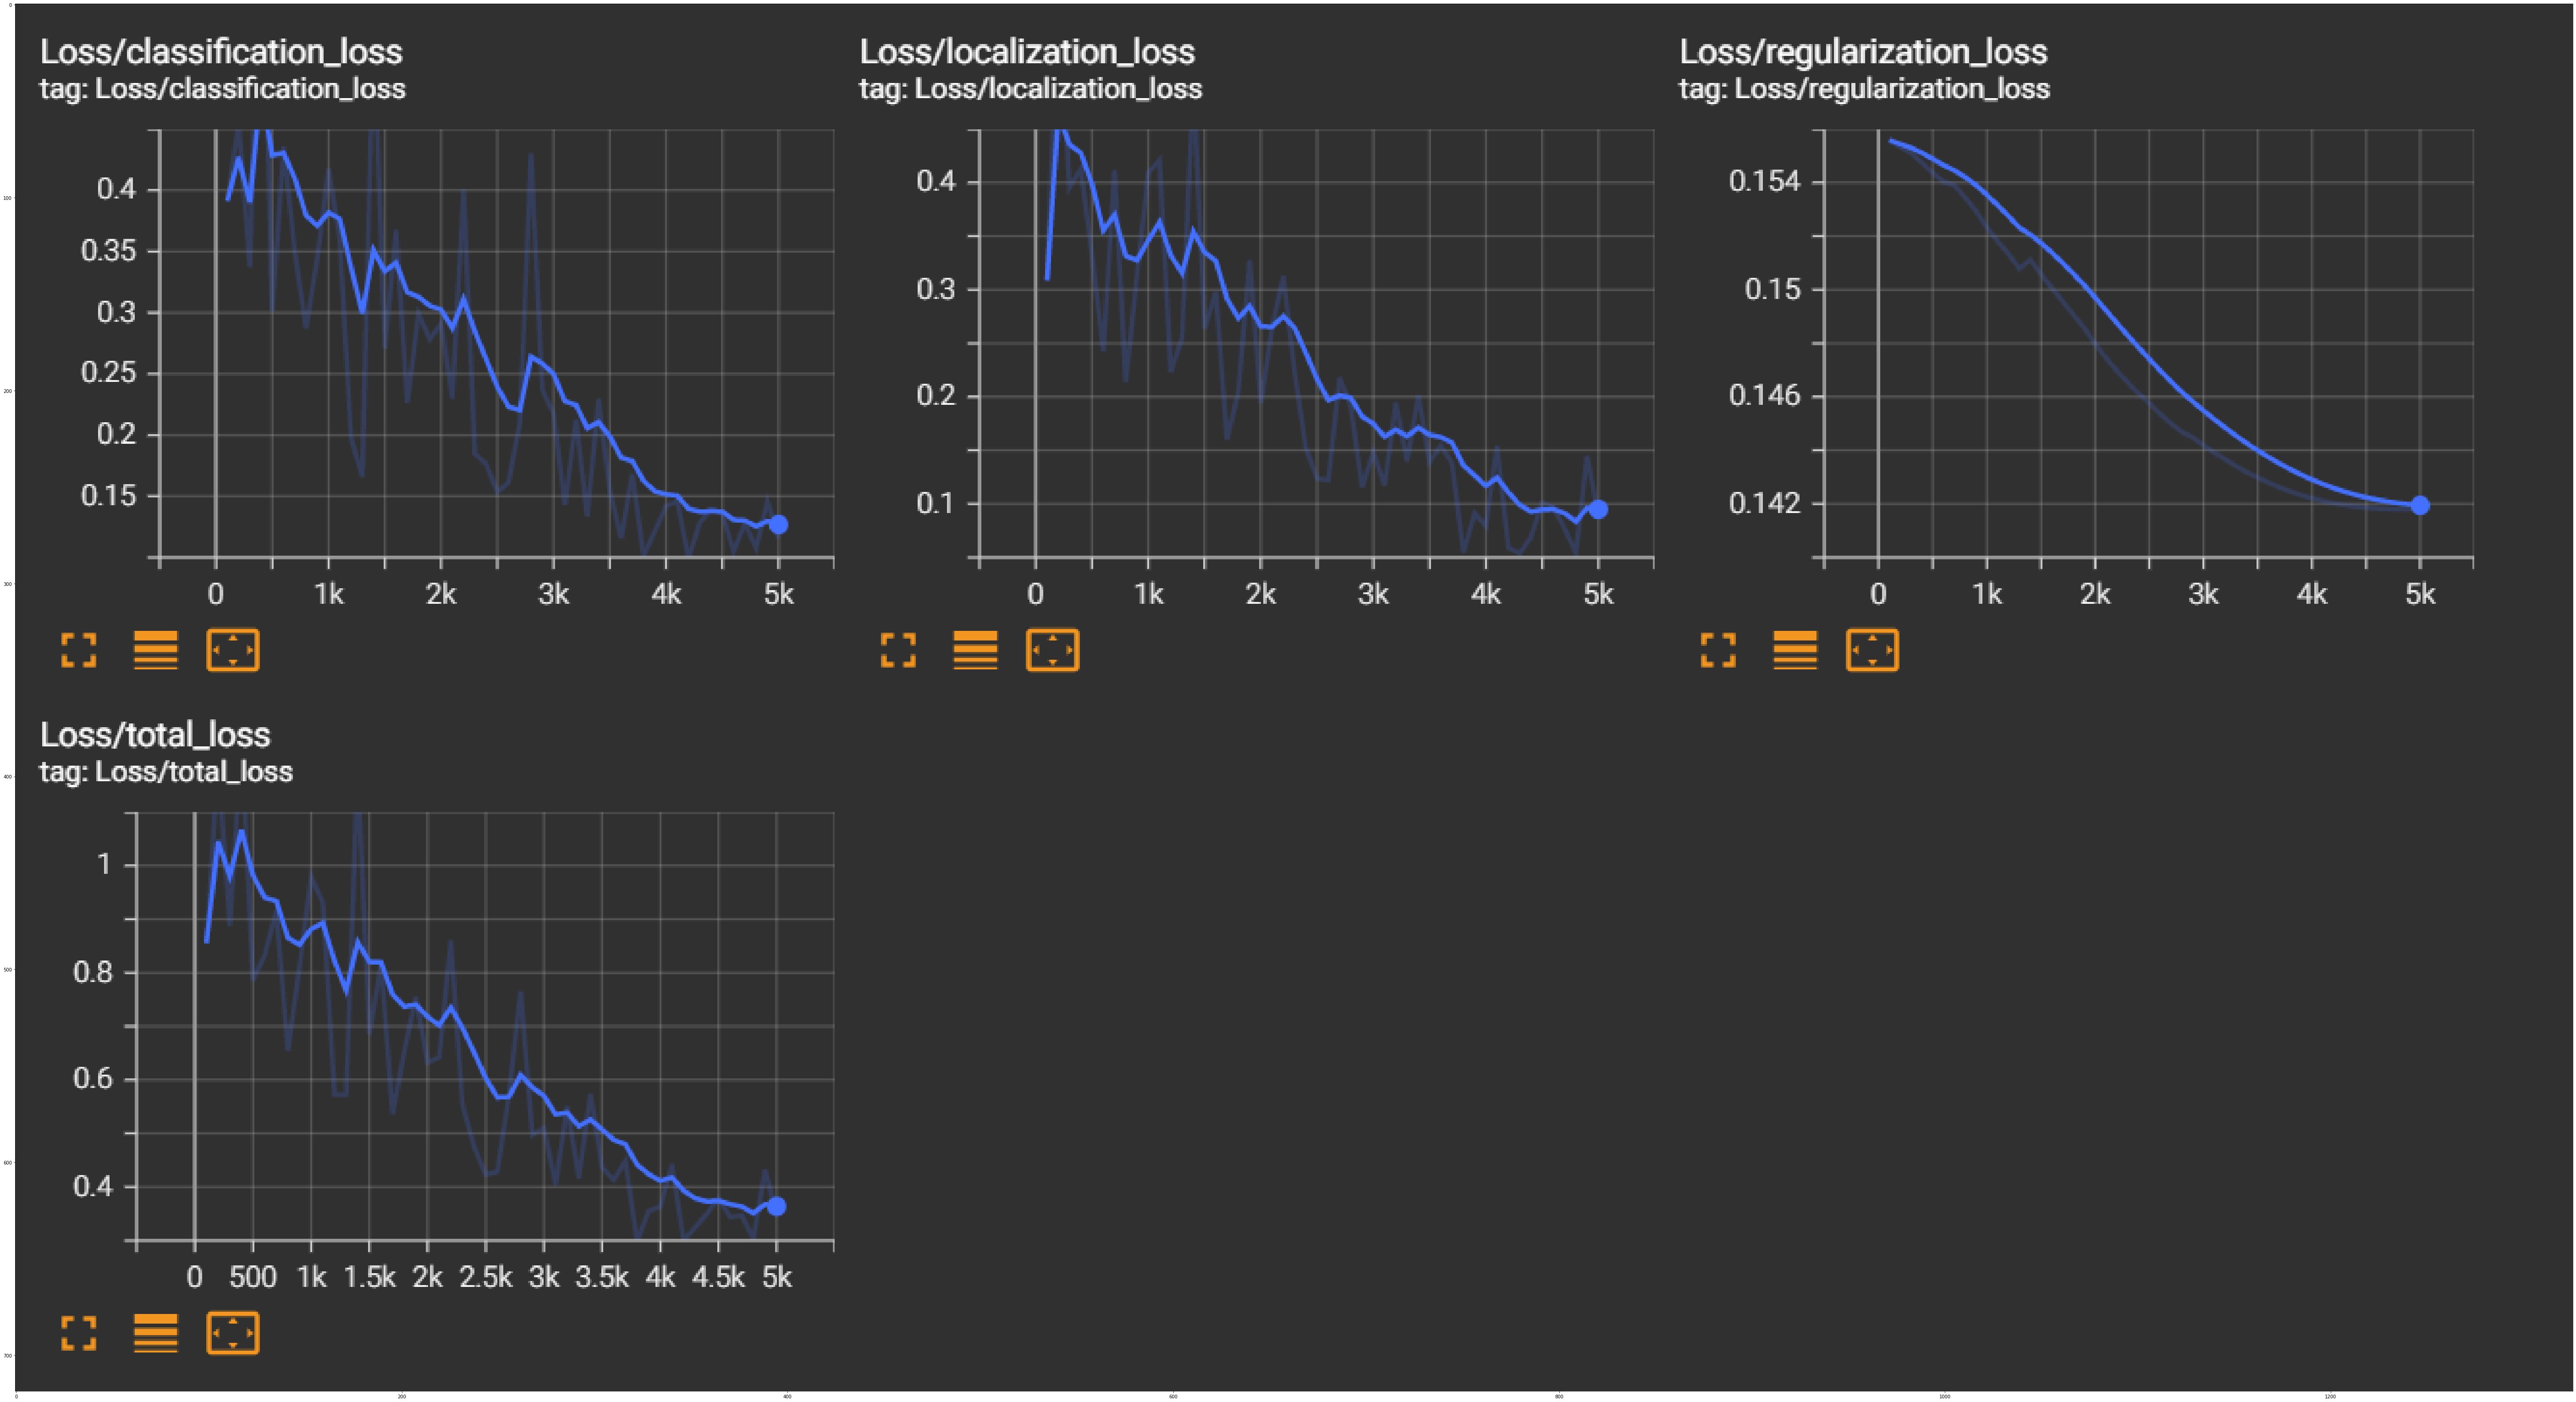

In [10]:
imshow(cv2.imread("C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/ssd_fpnlite.png"))

### ssd_mobilenet_v2_320x320 Evaluation

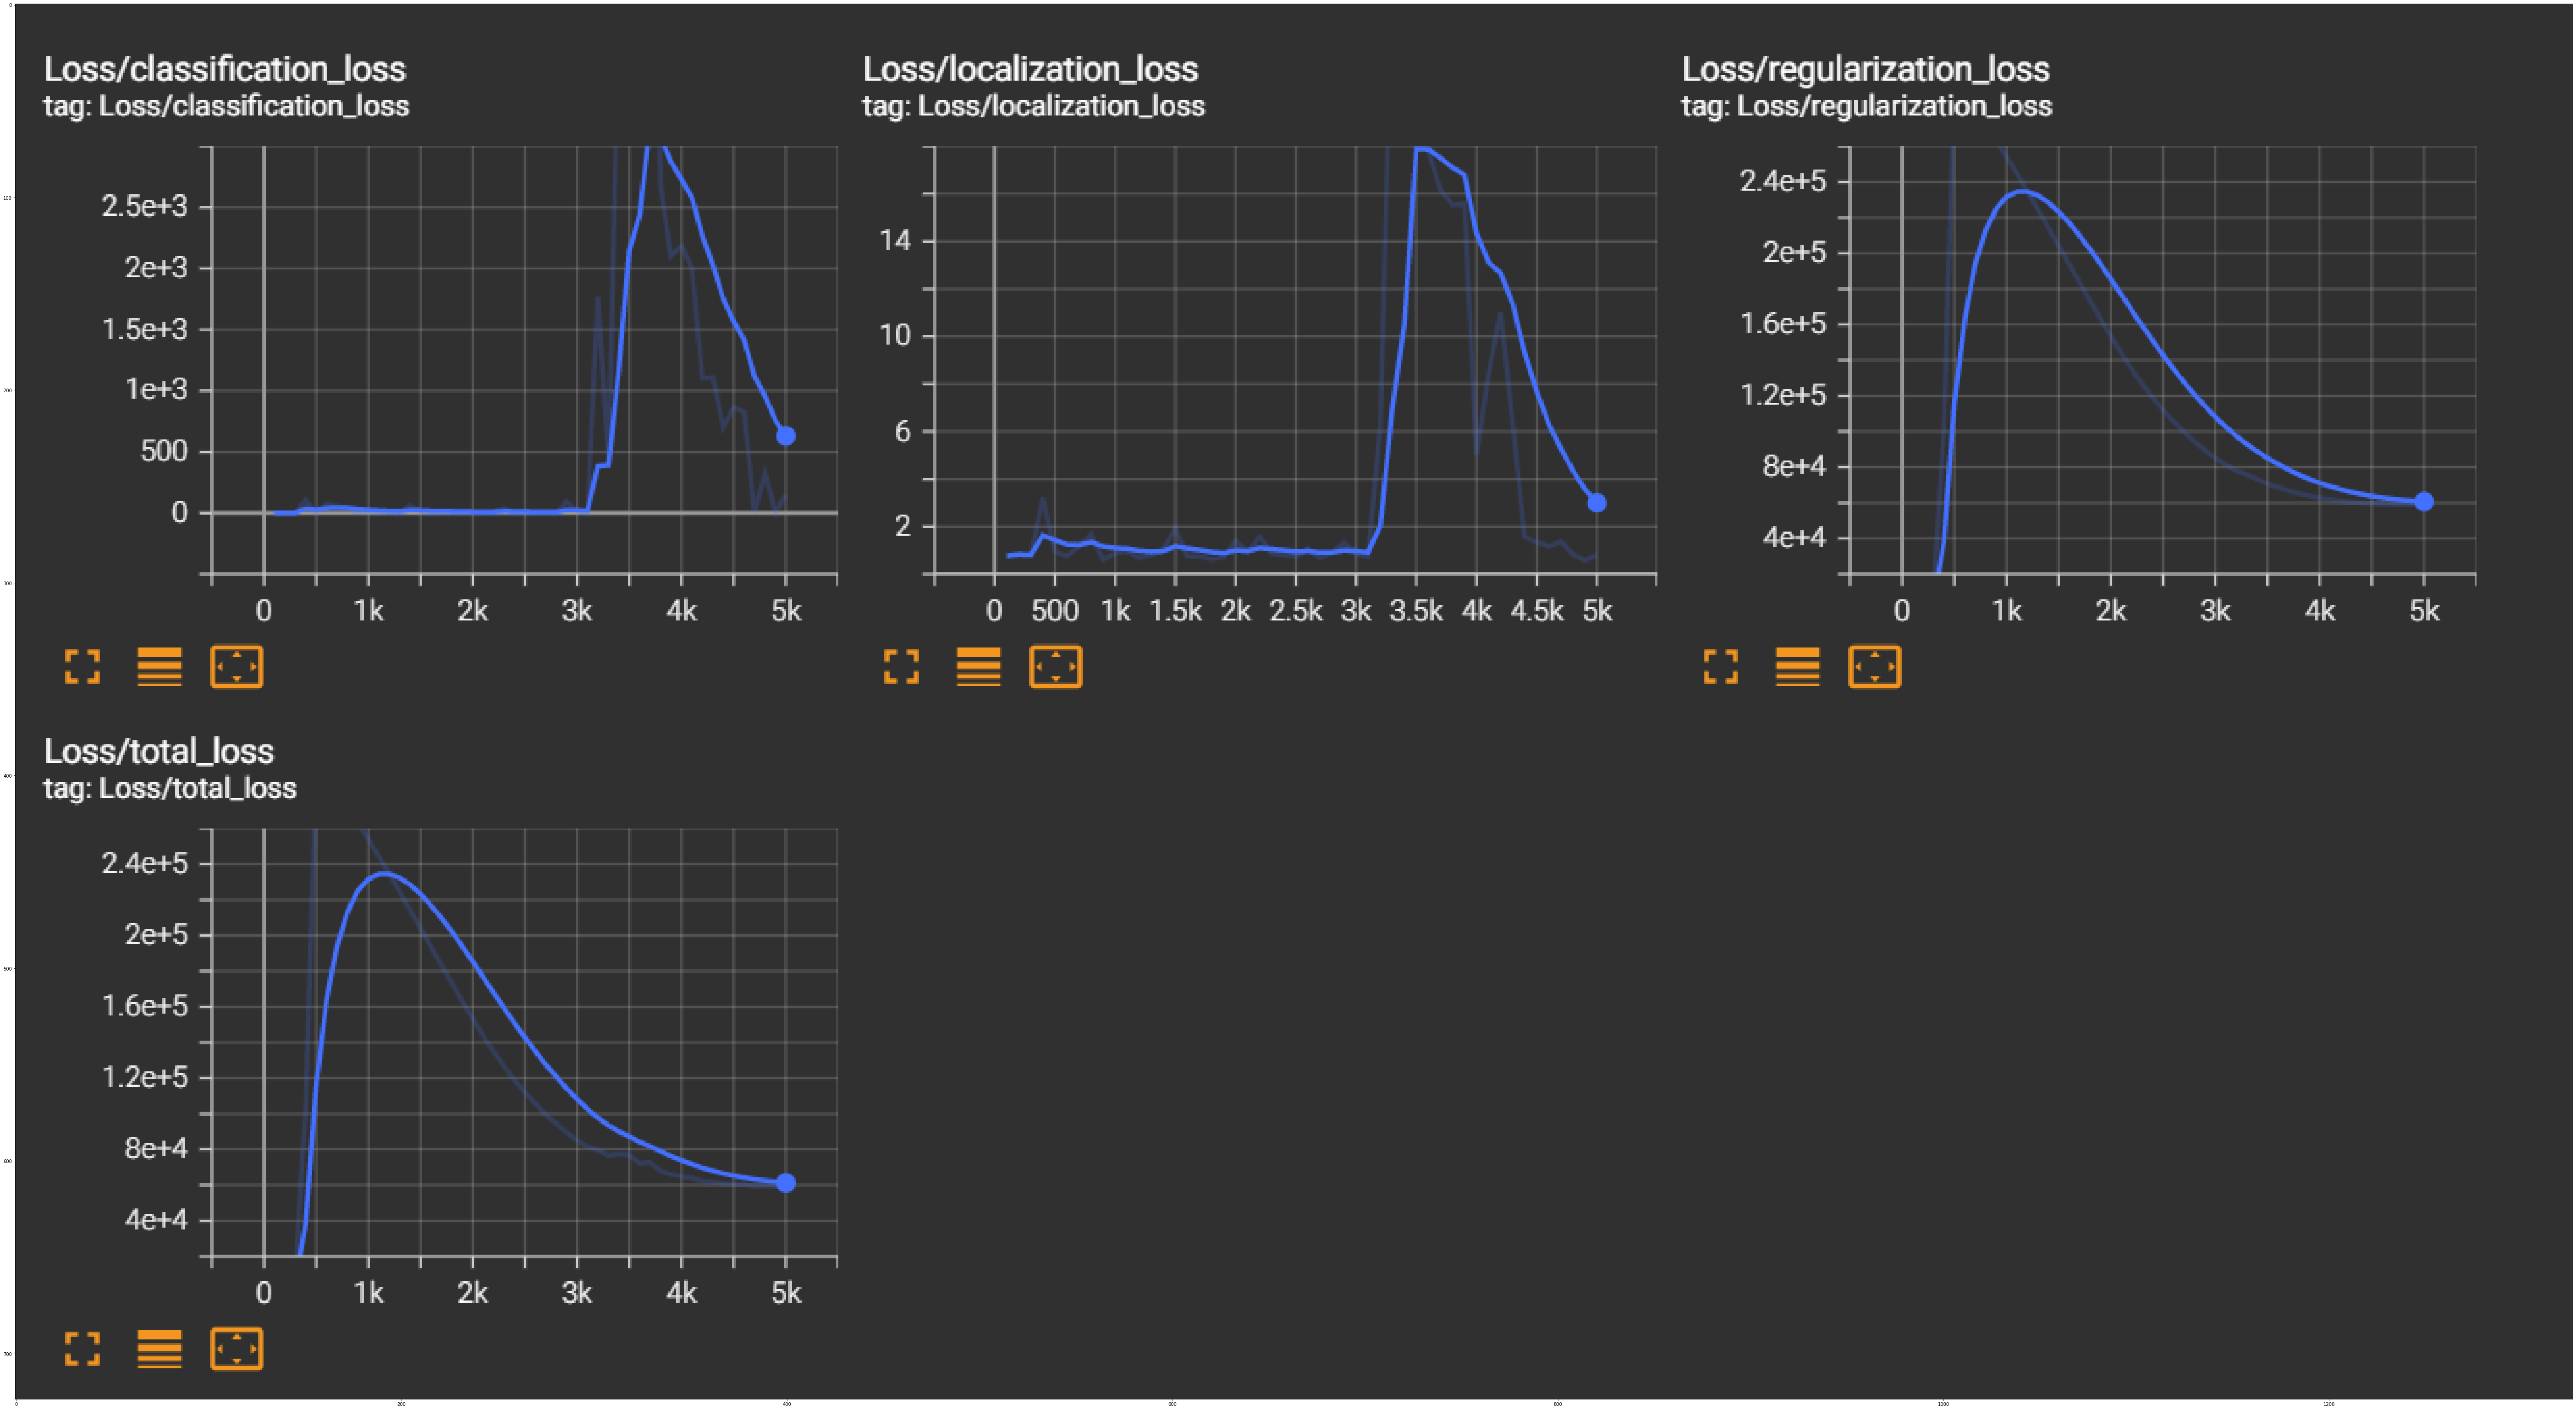

In [11]:
imshow(cv2.imread("C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/ssd_base.png"))

### ssd_resnet Evaluation

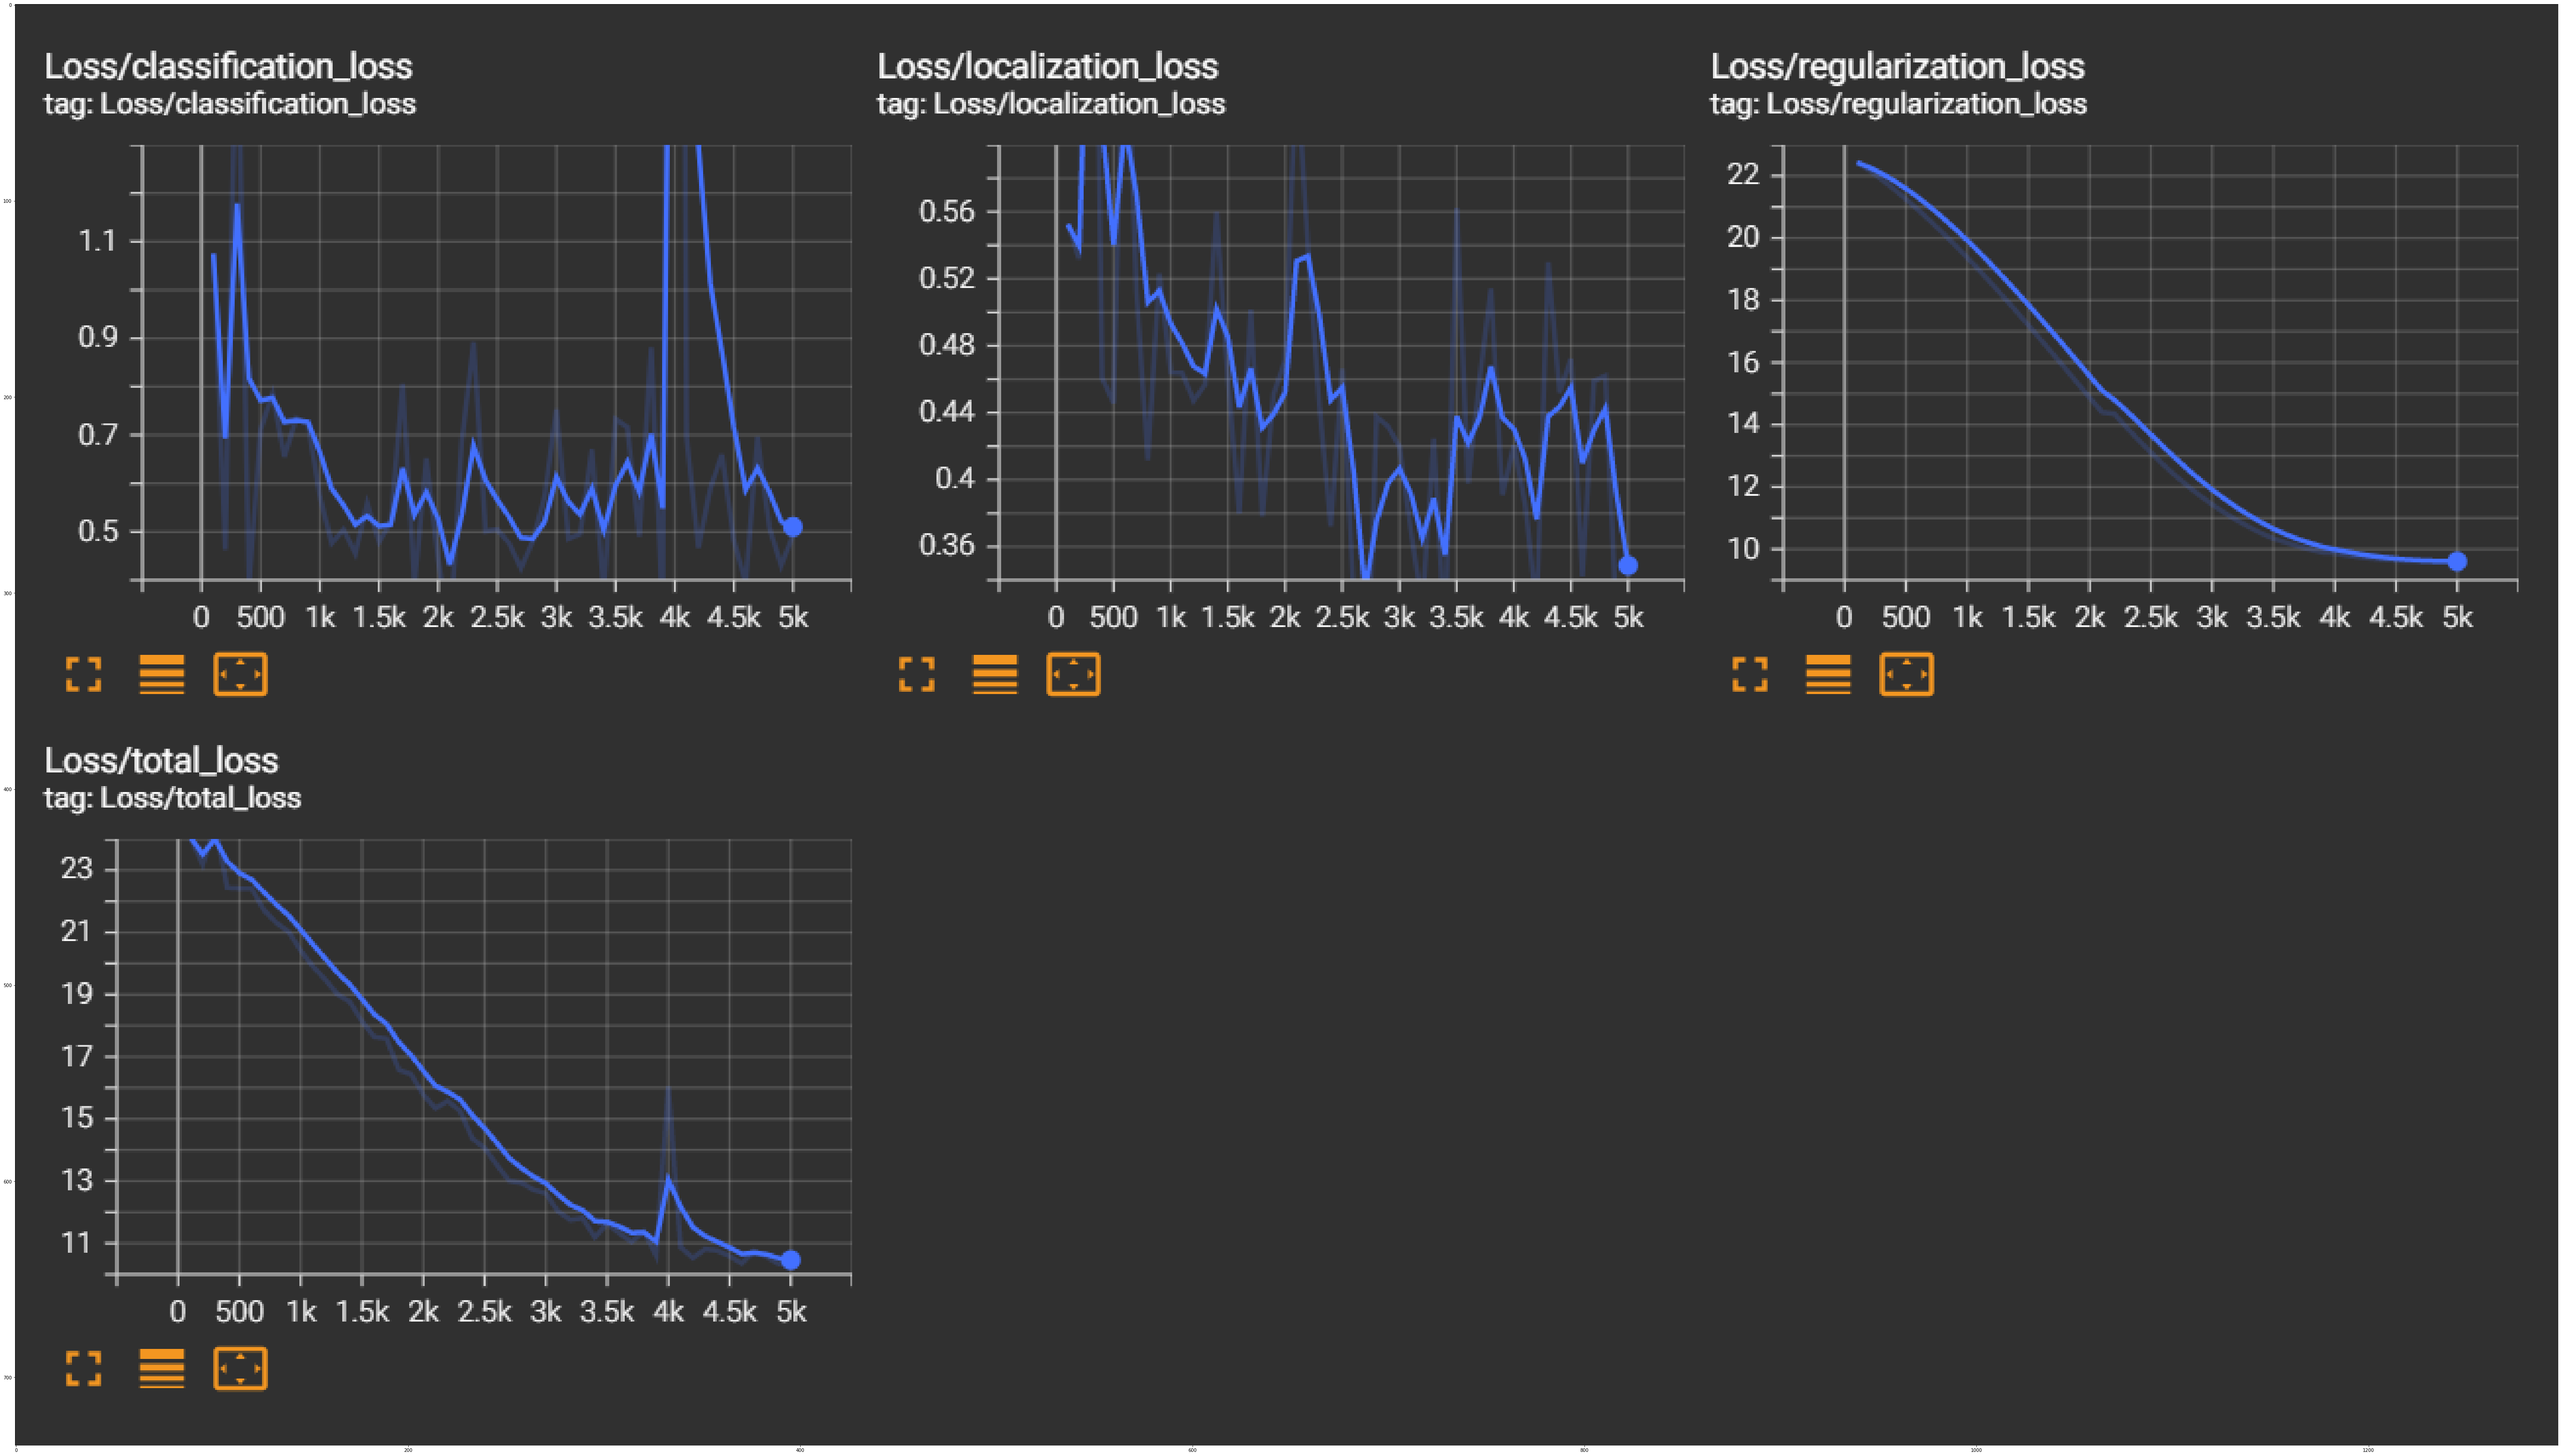

In [13]:
imshow(cv2.imread("C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/ssd_resnet.png"))

We thus settle on the SSD 320x320 with the FPNLite support which as the tensorboard shows, has a total loss that graudually falls down to below 0.2

## Set a path to an image to run the object detection on

In [10]:
# PROVIDE PATHS
IMAGE_PATHS = 'C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/dentalTrain/img1 Images 26.png'
PATH_TO_MODEL_DIR = 'C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/exported-models/my_modelssd'
PATH_TO_LABELS = 'C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/annotations/label_map.pbtxt'
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

Loading model...Done! Took 17.441853046417236 seconds
Running inference for C:/Users/hnsik/Softwares/Tensorflow/CustomDetection/images/dentalTrain/img1 Images 26.png... 

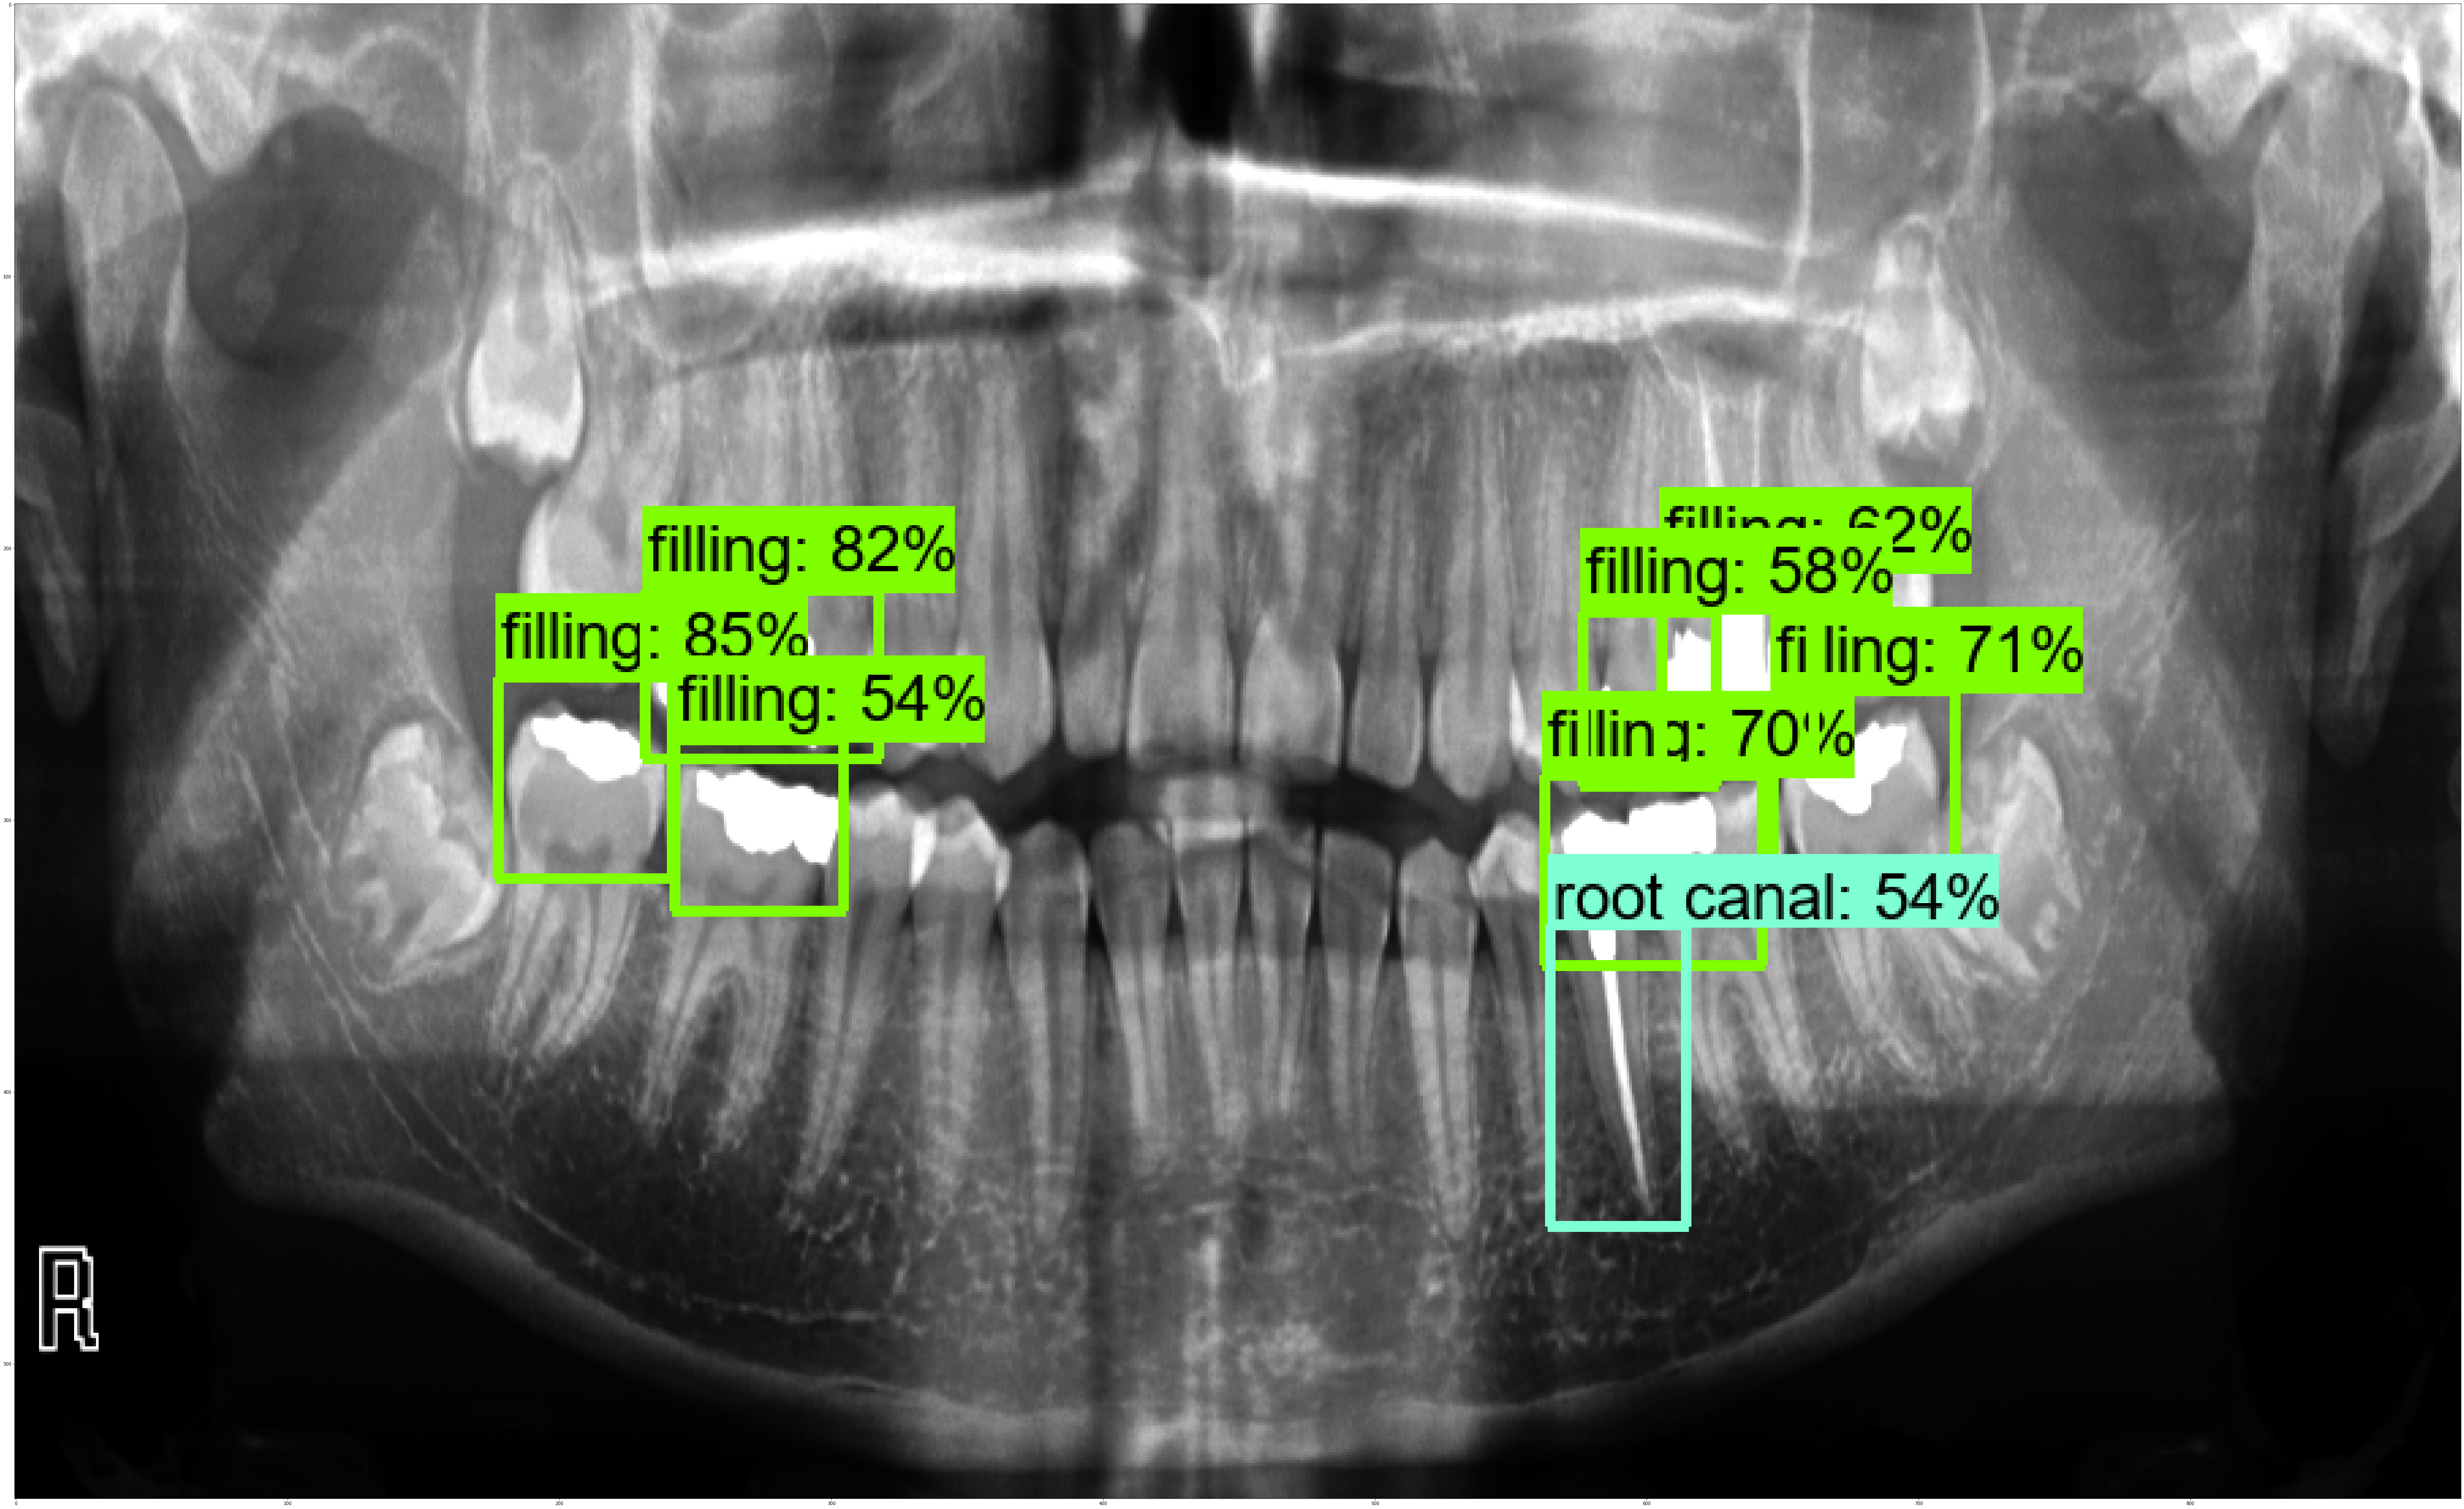

-1

In [11]:
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)



# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.60)

# LOAD THE MODEL

print('Loading model...', end='')
start_time = time.time()

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# LOAD LABEL MAP DATA FOR PLOTTING

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)



def load_image_into_numpy_array(path):

    return np.array(Image.open(path))




print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

# SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.5,
      agnostic_mode=False)
imshow(image_with_detections)
# DISPLAYS OUTPUT IMAGE
cv2.imshow("img",image_with_detections)


cv2.waitKey(0) 
# CLOSES WINDOW ONCE KEY IS PRESSED